In [7]:
import os
import random
from glob import glob
from PIL import Image,ImageOps
import matplotlib.pyplot as plt

In [8]:
import cv2
import numpy as np

In [10]:
## creating Dataset
random.seed(1)
IMAGE_SIZE = 128
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 300

In [156]:
import tensorflow as tf

In [169]:


def autocontrast(tensor, cutoff=0):
    tensor = tf.cast(tensor, dtype=tf.float32)
    min_val = tf.reduce_min(tensor)
    max_val = tf.reduce_max(tensor)
    range_val = max_val - min_val
    adjusted_tensor = tf.clip_by_value(tf.cast(tf.round((tensor - min_val - cutoff) * (255 / (range_val - 2 * cutoff))), tf.uint8), 0, 255)
    return adjusted_tensor

def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = autocontrast(image)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped


def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [170]:
train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("./lol_dataset/our485/high/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("./lol_dataset/our485/high/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))
test_enhanced_images = sorted(glob("./lol_dataset/eval15/high/*"))

In [171]:
train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)

In [220]:
import tensorflow as tf

def transformer_network():
    inputs = tf.keras.layers.Input(shape=(None, None, 3))
    batch_size = tf.shape(inputs)[0]
    
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(conv2)
    
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(conv2)
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(conv2)
    
    res1 = residual_block(conv3, 128)
    res2 = residual_block(res1, 128)
    res3 = residual_block(res2, 128)
    res4 = residual_block(res3, 128)
    res5 = residual_block(res4, 128)
    
    deconv1 = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(res5)
    deconv2 = tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(deconv1)
    
    outputs = tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(deconv2)
    outputs=tf.keras.layers.add([inputs, outputs])

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

def residual_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.add([inputs, x])
    x = tf.keras.layers.Activation('relu')(x)
    return x


In [221]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
    layer.trainable = False
outputs = [vgg.get_layer('block3_conv3').output, vgg.get_layer('block4_conv3').output]
model1 = tf.keras.models.Model(inputs=vgg.input, outputs=outputs)

In [222]:

def perceptual_loss(y_true, y_pred):
    y_true_features = model1(y_true)
    y_pred_features = model1(y_pred)
    loss = tf.reduce_mean(tf.square(y_true_features[0] - y_pred_features[0])) + tf.reduce_mean(tf.square(y_true_features[1] - y_pred_features[1]))
    return loss 
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3))) 
def loss(y_true,y_pred):
    return  + 0.5*perceptual_loss(y_true, y_pred)  + 0.4*charbonnier_loss(y_true, y_pred)

In [223]:
def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)

In [224]:
model = transformer_network()

In [225]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, loss=loss, metrics=[peak_signal_noise_ratio]
)

In [226]:
history = model.fit(train_dataset,validation_data=val_dataset,epochs=50)

Epoch 1/50
75/75 [==============================] - 13s 153ms/step - loss: 9.9720 - peak_signal_noise_ratio: 62.2790 - val_loss: 7.0698 - val_peak_signal_noise_ratio: 64.1572
Epoch 2/50
75/75 [==============================] - 11s 150ms/step - loss: 7.1553 - peak_signal_noise_ratio: 64.4780 - val_loss: 6.4285 - val_peak_signal_noise_ratio: 66.4658
Epoch 3/50
75/75 [==============================] - 11s 151ms/step - loss: 6.2211 - peak_signal_noise_ratio: 65.6490 - val_loss: 5.5251 - val_peak_signal_noise_ratio: 66.6507
Epoch 4/50
75/75 [==============================] - 11s 151ms/step - loss: 5.7589 - peak_signal_noise_ratio: 66.0233 - val_loss: 5.4923 - val_peak_signal_noise_ratio: 67.3426
Epoch 5/50
75/75 [==============================] - 11s 152ms/step - loss: 5.5234 - peak_signal_noise_ratio: 66.2548 - val_loss: 5.1068 - val_peak_signal_noise_ratio: 66.9525
Epoch 6/50
75/75 [==============================] - 11s 152ms/step - loss: 5.4164 - peak_signal_noise_ratio: 66.2214 - val_lo

In [251]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = tf.keras.preprocessing.image.img_to_array(original_image)
    image = autocontrast(image)
    image = tf.cast(image,dtype=tf.float32) / 255.0
    image = np.expand_dims(image, axis=0)
    output = model.predict(image,verbose=0)
    output_image = output[0] * 255.0
    output_image = output_image.clip(0, 255)
    output_image = output_image.reshape(
        (np.shape(output_image)[0], np.shape(output_image)[1], 3)
    )
    output_image = Image.fromarray(np.uint8(output_image))
    original_image = Image.fromarray(np.uint8(original_image))
    return output_image

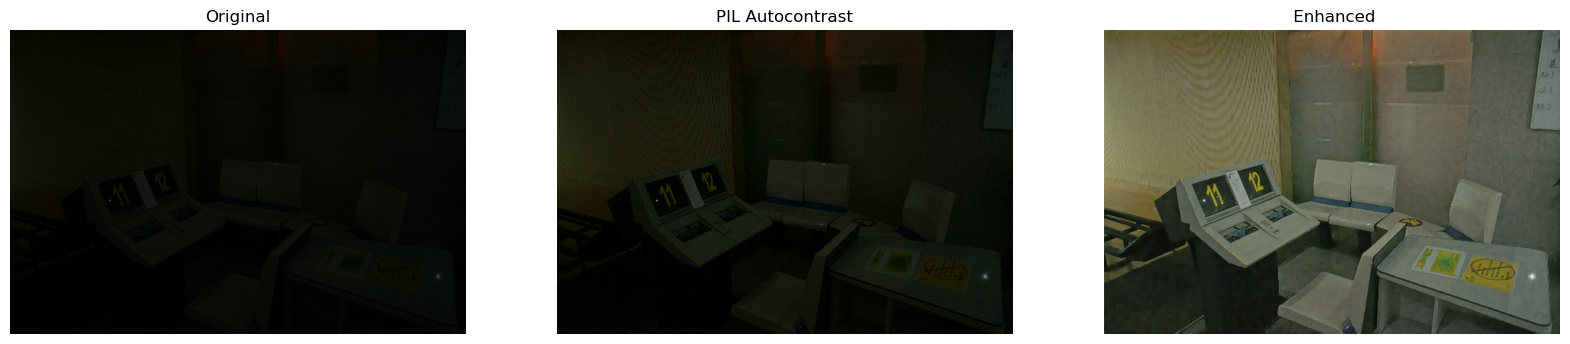

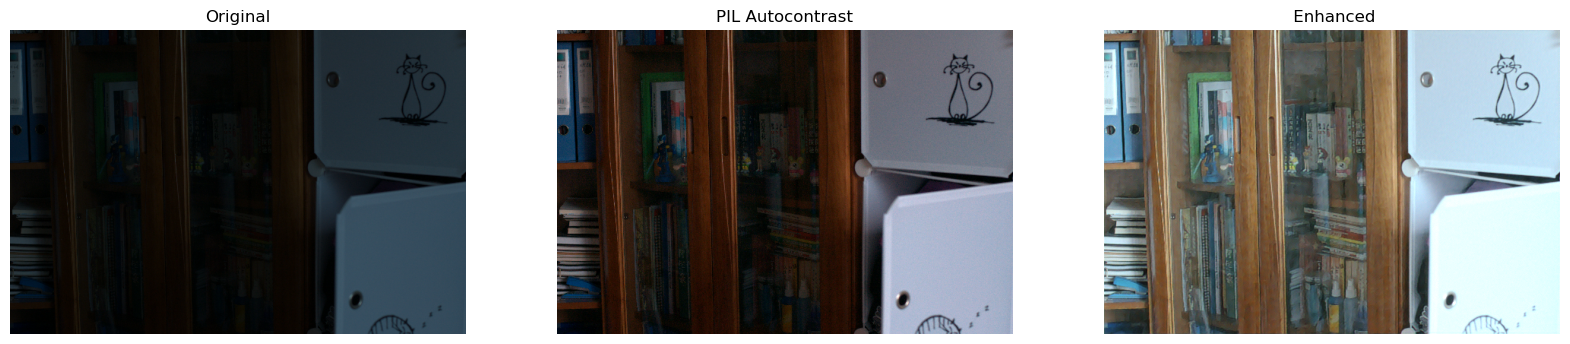

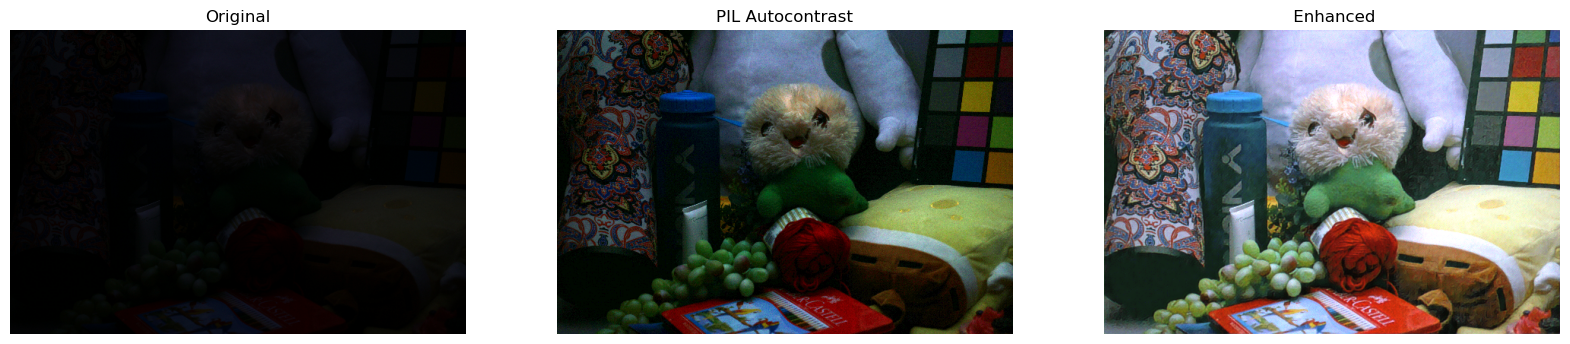

In [252]:
random.seed(10)
for low_light_image in random.sample(test_low_light_images, 3):
    original_image = Image.open(low_light_image)
    enhanced_image = infer(original_image)
    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image],
        ["Original", "PIL Autocontrast", " Enhanced"],
        (20, 12),
    )

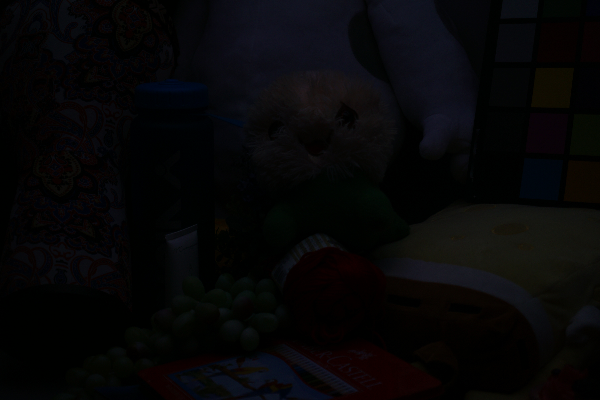

In [255]:
original_image

CPU times: total: 297 ms
Wall time: 349 ms


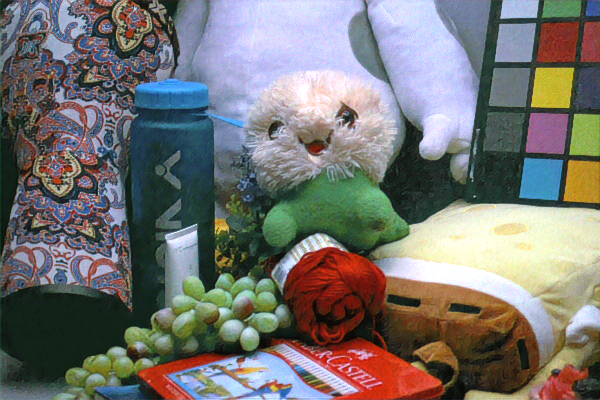

In [258]:
%%time
infer(original_image)

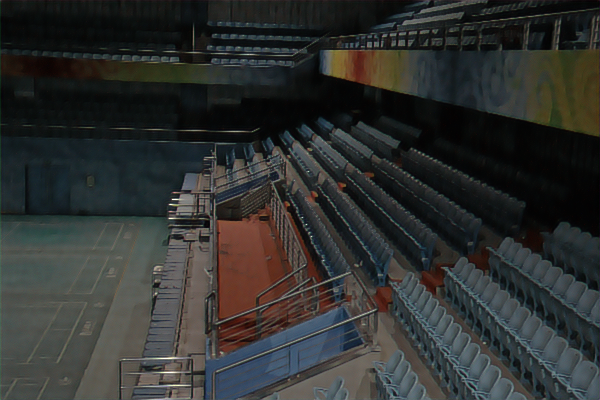

In [230]:
ImageOps.autocontrast(enhanced_image)

In [262]:
# define a video capture object
vid = cv2.VideoCapture(0)
  
while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
    frame = np.array(frame)
    frame1 = Image.fromarray(frame)
    frame2 = np.array(ImageOps.autocontrast(frame1))
    
    frame1 = np.array(infer(frame1))
    
  
    # Display the resulting frame
    cv2.imshow('frame', frame)
    cv2.imshow('frame1', frame1)
    cv2.imshow('frame2', frame2)
    
    
    # the 'q' button is set as theq
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

In [233]:
img=Image.open('test_2.jpeg')

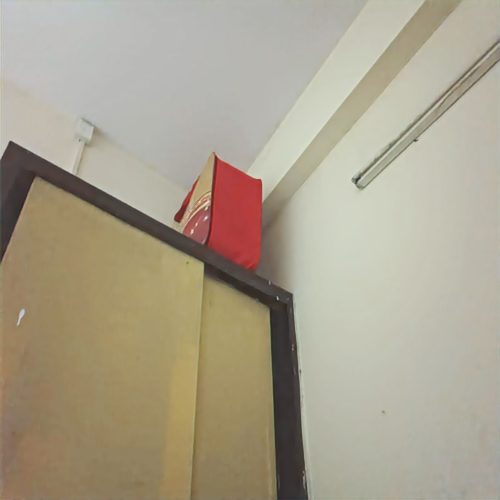

In [234]:
infer(img.resize((500,500),resample=None))

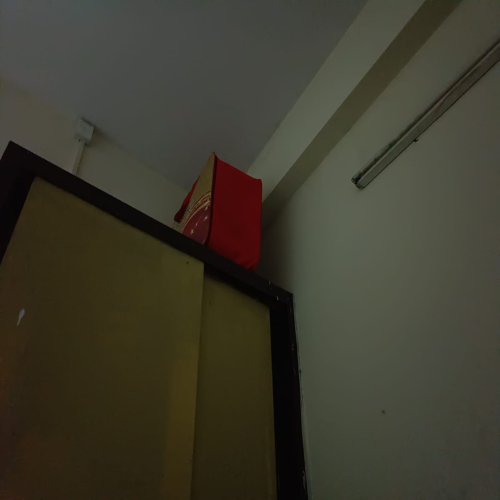

In [203]:
img.resize((500,500),resample=None)

In [260]:
model.save_weights('.model_transformer/transformer_')


In [211]:
img=Image.open('test_3.jpeg')

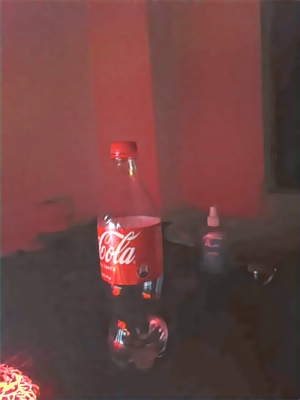

In [232]:
infer(img.resize((300,400),resample=None))

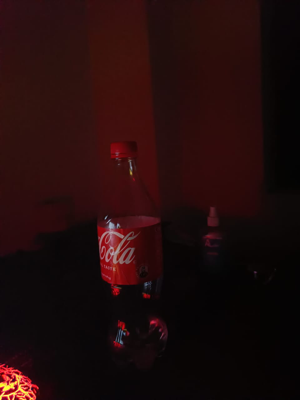

In [219]:
img.resize((300,400),resample=None)

In [217]:
np.array(img).shape

(1280, 960, 3)

In [263]:
model.save('transformer_68.h5')

In [264]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\PRIYAN~1\AppData\Local\Temp\tmp3oyc4cao\assets


INFO:tensorflow:Assets written to: C:\Users\PRIYAN~1\AppData\Local\Temp\tmp3oyc4cao\assets


In [265]:
with open('my_model.tflite', 'wb') as f:
    f.write(tflite_model)